In [3]:
import yfinance as yahooFinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date

In [33]:
daily_apple = yahooFinance.download("AAPL", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_appleBefore = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [45]:
appleDiff = daily_apple['Close'].diff()
appleDiff.dropna(inplace=True)


In [10]:
daily_bitcoin.index



DatetimeIndex(['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04',
               '2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08',
               '2023-09-09', '2023-09-10',
               ...
               '2024-08-22', '2024-08-23', '2024-08-24', '2024-08-25',
               '2024-08-26', '2024-08-27', '2024-08-28', '2024-08-29',
               '2024-08-30', '2024-08-31'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

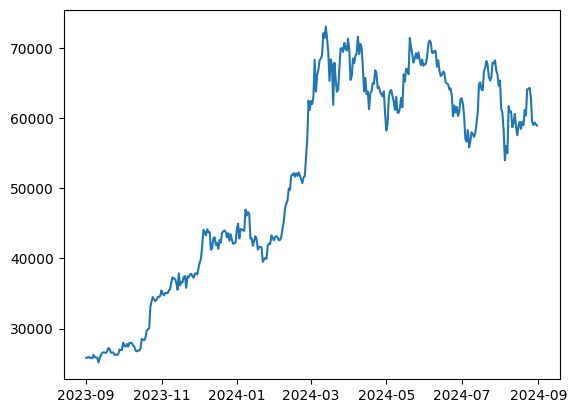

In [12]:
plt.plot(daily_bitcoin['Close'])



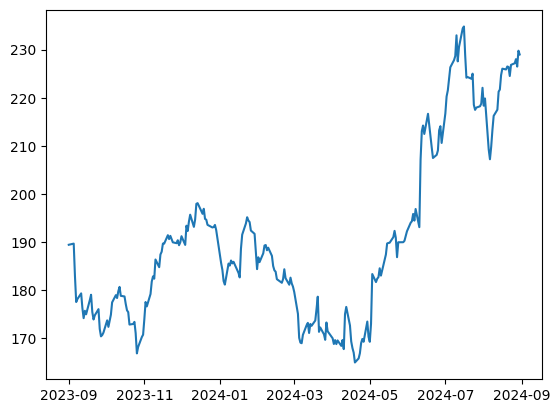

In [13]:
plt.plot(daily_apple['Close'])

In [4]:
#https://mayerkrebs.com/relative-strength-index-rsi-in-python/
#RSI
def rsi(closeArray, period=14):
    dayDiff = closeArray.diff()
    dayDiff.dropna(inplace=True)
    diffPos = dayDiff.copy()
    diffNeg = dayDiff.copy()

    diffPos[diffPos<0] = 0
    diffNeg[diffNeg>0] = 0
    avgPos = diffPos.rolling(period).mean()
    avgNeg = diffNeg.rolling(period).mean().abs()

    rsi = 100* avgPos / (avgPos + avgNeg)
    rsi.head(20)
    return rsi


In [5]:
#https://dayanand-shah.medium.com/exponential-moving-average-and-implementation-with-python-1890d1b880e6
#EMA
##def ema(closeArray, period):
  #  ema = closeArray.ewm(span=period, adjust=False).mean()
   # return ema



    #définition d'un exponential movind average sur un 1d array

def ema(closeArray, period):
    
    ema = np.zeros_like(closeArray)
    
    alpha = 2 /(period + 1)
    
    for i in range(period, len(closeArray)):
        
        if np.isnan(closeArray[i]) :
            
            continue
        
        else:
            
            ema[i] = alpha*closeArray[i] + (1 - alpha)*ema[i-1]
        
        
    ema[ema==0]=np.nan
    
    return ema


    
def PEMA(closeArray,period):
    MA1 = ema(closeArray,period)
    MA2 = ema(MA1,period)
    MA3 = ema(MA2,period)
    MA4 = ema(MA3,period)
    MA5 = ema(MA4,period)
    MA6 = ema(MA5,period)
    MA7 = ema(MA6,period)
    MA8 = ema(MA7,period)
    PEMA = 8*MA1 - 28*MA2 + 56*MA3 -70*MA4 + 56*MA5 - 28*MA6 + 8*MA7 - MA8
    return PEMA



    

In [ ]:
appleRSI = rsi(daily_apple['Close'])

ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(appleRSI, color='orange', linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')


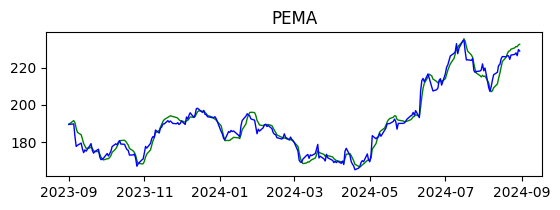

In [44]:
applePEMA = PEMA(daily_appleBefore['Close'].to_numpy(), 34)

ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Second chart
# Plot the EMA
ax2.set_title('PEMA')
applePEMADate =  applePEMA[len(applePEMA) - len(daily_apple.index):]
ax2.plot(daily_apple.index, applePEMADate, color='green', linewidth=1)
ax2.plot(daily_apple.index, daily_apple['Close'], color='blue', linewidth=1)

In [7]:
def pemaSignals(pema):
    deltaPEMA = np.diff(pema)
    
    buySignal = np.zeros_like(deltaPEMA)
    sellSignal = np.zeros_like(deltaPEMA)
    
    for i in range(len(deltaPEMA)):
        if i-2 > 0:
            if deltaPEMA[i - 1] < 0. and deltaPEMA[i] > 0. :
                buySignal[i] = 1
            else:
                   buySignal[i] = np.nan
        else:
            buySignal[i] = np.nan
    
    for i in range(len(deltaPEMA)):
        if i-2 > 0:
            if deltaPEMA[i - 1] > 0. and deltaPEMA[i] < 0. :
                sellSignal[i] = 1
            else:
                   sellSignal[i] = np.nan
        else:
            sellSignal[i] = np.nan
        
    buySignal[len(buySignal)-1] = np.nan
    sellSignal[len(buySignal)-1] = np.nan

    return buySignal, sellSignal


In [26]:
def moneyMade(buySignals, sellSignals, stockPrices, titre, showBuyHold):
    cashAmount = 0
    hasInvested = False
    initialBoughtAction = 0
    stockAmount = 1.

    
    for i in range(len(stockPrices)):
        if not hasInvested:
            if(buySignals[i] == 1):
                hasInvested = True
                initialBoughtAction = stockPrices.iloc[i]
                cashAmount = initialBoughtAction
        
        else:   
            if(buySignals[i] == 1):
                stockAmount = cashAmount/stockPrices.iloc[i]

            if(sellSignals[i] == 1):
                cashAmount = stockAmount*stockPrices.iloc[i]

    profit = 100*(cashAmount / initialBoughtAction - 1)
    buyHold = 100*(stockPrices.iloc[i-1]/stockPrices.iloc[0] - 1)
    print(titre +  ' Profit :', profit, '%')
    if(showBuyHold):
        print('Acheter action Profit: ', buyHold, '%')
    return
    

In [27]:

def pemaResult(daily, dailyBefore, pemaPeriod, titre, showPlot):
    dailyPemaLong = PEMA(dailyBefore['Close'].to_numpy(), pemaPeriod)
    dailyPema = dailyPemaLong[(len(dailyPemaLong)-1) - len(daily.index):]

    
    #diffPEMA = np.append(np.diff(dailyPema), 0)
    buySignal, sellSignal = pemaSignals(dailyPema)

    if(showPlot):
        dailyPema = dailyPema[0:-1]
        fig, ax = plt.subplots(figsize=(11, 6))
        priceArray = daily['Close'].to_numpy()
        lowest_point = np.min(priceArray)
        max_point = np.max(priceArray)
        ax.plot(daily.index, buySignal*daily['Close'], '*g')
        ax.plot(daily.index, sellSignal*daily['Close'], '*r')
        ax.plot(daily.index, dailyPema, color='purple', linewidth=1)
        ax.plot(daily.index, daily['Close'])
        plt.title(titre)
        ax.autoscale_view()
        fig.autofmt_xdate()
        
       # ax.fill_between(daily.index, lowest_point, max_point, where= diffPEMA >= 0, facecolor = 'green', alpha = .2)
       # ax.fill_between(daily.index, lowest_point, max_point, where= diffPEMA < 0, facecolor = 'red', alpha = .2)
    
        buySignalPd = pd.Series(list(buySignal), index=list(range(0,len(daily.index))))
        sellSignalPd = pd.Series(list(sellSignal), index=list(range(0,len(daily.index))))
    
        begi = 0
        for i in range(len(daily.index)):
            if(begi == 0):
                if(buySignal[i]==1):
                    ax.fill_between(daily.index[0:i], max_point, lowest_point, facecolor = 'green', alpha = .2)
                    begi = i
            else:
                if(sellSignal[i] == 1):
                    ax.fill_between(daily.index[begi-1:i], max_point, lowest_point, facecolor = 'green', alpha = .2)
                    begi = i
                    
                if(buySignal[i] ==1):
                    ax.fill_between(daily.index[begi-1:i], max_point, lowest_point, facecolor = 'red', alpha = .2)
                    begi = i

    
    moneyMade(buySignal, sellSignal, daily['Close'], titre, showPlot)
    return


In [28]:

def backTest(daily, dailyBefore, string, freq = ' jours'):
    
    for i in range(5,40):
        message = string + str(i) + freq
        pemaResult(daily, dailyBefore, i, message, False)
    
    return

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Apple PEMA 1 an période 5 jours Profit : 11.194432624921923 %
Apple PEMA 1 an période 6 jours Profit : 11.888121641313498 %
Apple PEMA 1 an période 7 jours Profit : 12.282818975331011 %
Apple PEMA 1 an période 8 jours Profit : 13.203910185953971 %
Apple PEMA 1 an période 9 jours Profit : 15.213251780973813 %
Apple PEMA 1 an période 10 jours Profit : 18.07146381378284 %
Apple PEMA 1 an période 11 jours Profit : 17.54078711989553 %
Apple PEMA 1 an période 12 jours Profit : 18.567233937572404 %
Apple PEMA 1 an période 13 jours Profit : 18.36606476378062 %
Apple PEMA 1 an période 14 jours Profit : 21.50027181608898 %
Apple PEMA 1 an période 15 jours Profit : 23.093922922796462 %
Apple PEMA 1 an période 16 jours Profit : 25.456053200287876 %
Apple PEMA 1 an période 17 jours Profit : 25.68708894325049 %
Apple PEMA 1 an période 18 jours Profit : 26.99887487261727 %
Apple PEMA 1 an période 19 jours Profit : 25.382198777675292 %
Apple PEMA 1 an période 20 jours Profit : 26.495927081991866 %
App

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Banque Nationale PEMA 1 an période 5 jours Profit : 14.611514080975475 %
Banque Nationale PEMA 1 an période 6 jours Profit : 16.387802320718304 %
Banque Nationale PEMA 1 an période 7 jours Profit : 19.02958804895267 %
Banque Nationale PEMA 1 an période 8 jours Profit : 18.570760116128415 %
Banque Nationale PEMA 1 an période 9 jours Profit : 19.570516786685776 %
Banque Nationale PEMA 1 an période 10 jours Profit : 15.467212088104908 %
Banque Nationale PEMA 1 an période 11 jours Profit : 13.903217375102495 %
Banque Nationale PEMA 1 an période 12 jours Profit : 15.326173726643134 %
Banque Nationale PEMA 1 an période 13 jours Profit : 15.379169361342093 %
Banque Nationale PEMA 1 an période 14 jours Profit : 12.464807010225654 %
Banque Nationale PEMA 1 an période 15 jours Profit : 16.15524881380994 %
Banque Nationale PEMA 1 an période 16 jours Profit : 15.036052776899966 %
Banque Nationale PEMA 1 an période 17 jours Profit : 16.465792405276037 %
Banque Nationale PEMA 1 an période 18 jours P

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


CAD-USD PEMA 1 an période 5 jours Profit : -1.0203736887203885 %
CAD-USD PEMA 1 an période 6 jours Profit : -2.4553145308492064 %
CAD-USD PEMA 1 an période 7 jours Profit : -2.7594208553239463 %
CAD-USD PEMA 1 an période 8 jours Profit : -2.5449189056290344 %
CAD-USD PEMA 1 an période 9 jours Profit : -2.492314608976065 %
CAD-USD PEMA 1 an période 10 jours Profit : -3.035787782554522 %
CAD-USD PEMA 1 an période 11 jours Profit : -2.5654232855169656 %
CAD-USD PEMA 1 an période 12 jours Profit : -3.7133911923000085 %
CAD-USD PEMA 1 an période 13 jours Profit : -3.188615669834105 %
CAD-USD PEMA 1 an période 14 jours Profit : -3.5299787403916927 %
CAD-USD PEMA 1 an période 15 jours Profit : -2.601726446473618 %
CAD-USD PEMA 1 an période 16 jours Profit : -2.376892952898213 %
CAD-USD PEMA 1 an période 17 jours Profit : -2.744791801575608 %
CAD-USD PEMA 1 an période 18 jours Profit : -2.9071763141938933 %
CAD-USD PEMA 1 an période 19 jours Profit : -3.3345429410593264 %
CAD-USD PEMA 1 an pér

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Signaux PEMA CA-USD août 2023 - juin 2024 (Période = 5) Profit : -1.0203736887203885 %
Acheter action Profit:  -4.790764758994914 %



[*********************100%%**********************]  1 of 1 completed


SP500 PEMA 1 an période 5 jours Profit : 13.290120302099751 %
SP500 PEMA 1 an période 6 jours Profit : 11.16245944458738 %
SP500 PEMA 1 an période 7 jours Profit : 13.40617553008039 %
SP500 PEMA 1 an période 8 jours Profit : 16.024147860457095 %
SP500 PEMA 1 an période 9 jours Profit : 14.909505964670844 %
SP500 PEMA 1 an période 10 jours Profit : 13.572740348334511 %
SP500 PEMA 1 an période 11 jours Profit : 12.569439656334191 %
SP500 PEMA 1 an période 12 jours Profit : 10.154117663236462 %
SP500 PEMA 1 an période 13 jours Profit : 11.22950352909864 %
SP500 PEMA 1 an période 14 jours Profit : 11.45672029580398 %
SP500 PEMA 1 an période 15 jours Profit : 13.123542985085157 %
SP500 PEMA 1 an période 16 jours Profit : 12.001777363809364 %
SP500 PEMA 1 an période 17 jours Profit : 12.001777363809364 %
SP500 PEMA 1 an période 18 jours Profit : 14.180933212651503 %
SP500 PEMA 1 an période 19 jours Profit : 16.118441605858425 %
SP500 PEMA 1 an période 20 jours Profit : 16.231054489777197 %
S

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Signaux PEMA SP500 août 2023 - juin 2024 (Période = 28) Profit : 15.023968921571097 %
Acheter action Profit:  18.78437147496843 %
Ubisoft PEMA 1 an période 5 jours Profit : -28.07752451812654 %
Ubisoft PEMA 1 an période 6 jours Profit : -25.92821485130372 %
Ubisoft PEMA 1 an période 7 jours Profit : -23.30709209319425 %
Ubisoft PEMA 1 an période 8 jours Profit : -25.98679067274614 %
Ubisoft PEMA 1 an période 9 jours Profit : -24.57669079004374 %
Ubisoft PEMA 1 an période 10 jours Profit : -25.007555587671206 %
Ubisoft PEMA 1 an période 11 jours Profit : -31.64185072718241 %
Ubisoft PEMA 1 an période 12 jours Profit : -33.37925944919444 %
Ubisoft PEMA 1 an période 13 jours Profit : -31.935887899141647 %


Ubisoft PEMA 1 an période 14 jours Profit : -33.49273557479505 %
Ubisoft PEMA 1 an période 15 jours Profit : -19.24454070452861 %
Ubisoft PEMA 1 an période 16 jours Profit : -21.570740145482247 %
Ubisoft PEMA 1 an période 17 jours Profit : -18.71206654166584 %
Ubisoft PEMA 1 an période 18 jours Profit : -17.02006616738383 %
Ubisoft PEMA 1 an période 19 jours Profit : -18.559902601748433 %
Ubisoft PEMA 1 an période 20 jours Profit : -18.185274304518963 %
Ubisoft PEMA 1 an période 21 jours Profit : -19.349037090808874 %
Ubisoft PEMA 1 an période 22 jours Profit : -19.349037090808874 %
Ubisoft PEMA 1 an période 23 jours Profit : -31.00317329826031 %
Ubisoft PEMA 1 an période 24 jours Profit : -27.14155596873176 %
Ubisoft PEMA 1 an période 25 jours Profit : -35.716673637306926 %
Ubisoft PEMA 1 an période 26 jours Profit : -34.65639138108055 %
Ubisoft PEMA 1 an période 27 jours Profit : -34.24425238986869 %
Ubisoft PEMA 1 an période 28 jours Profit : -34.24425238986869 %
Ubisoft PEMA 1 an p

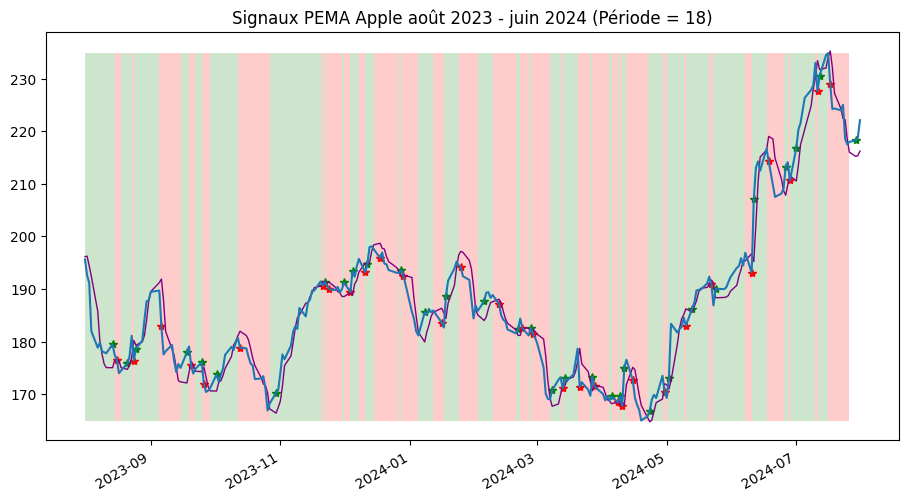

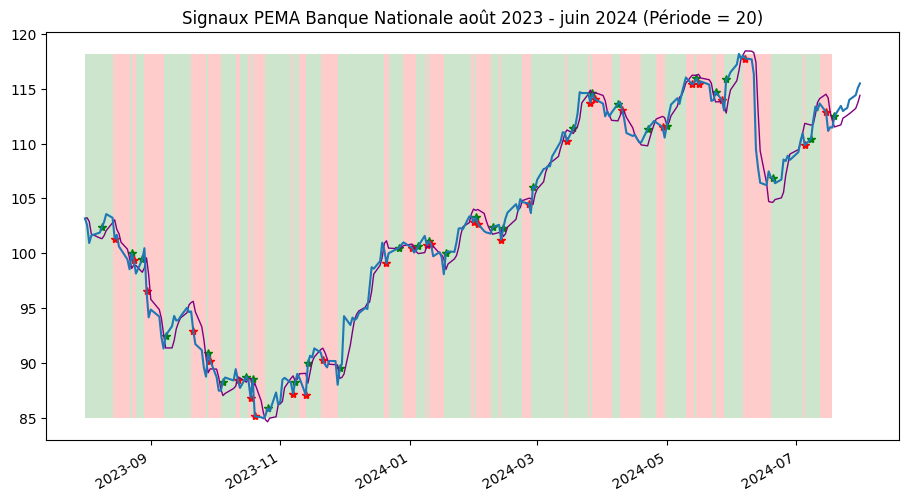

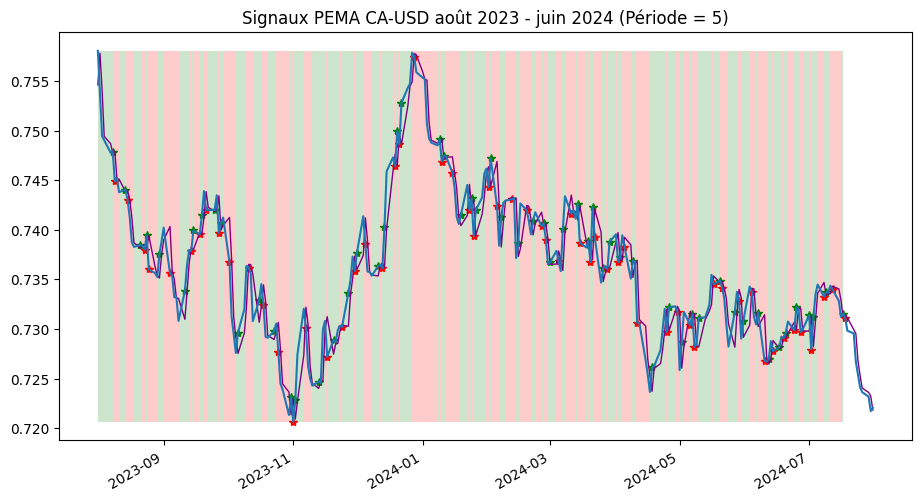

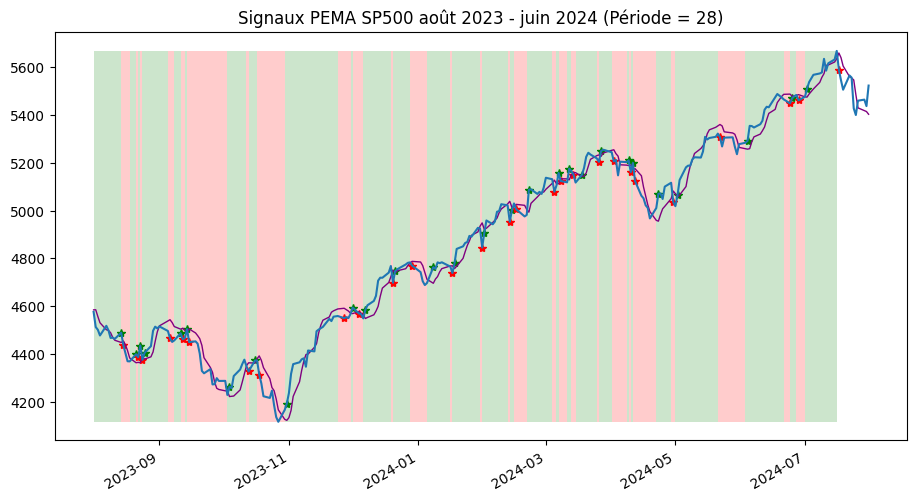

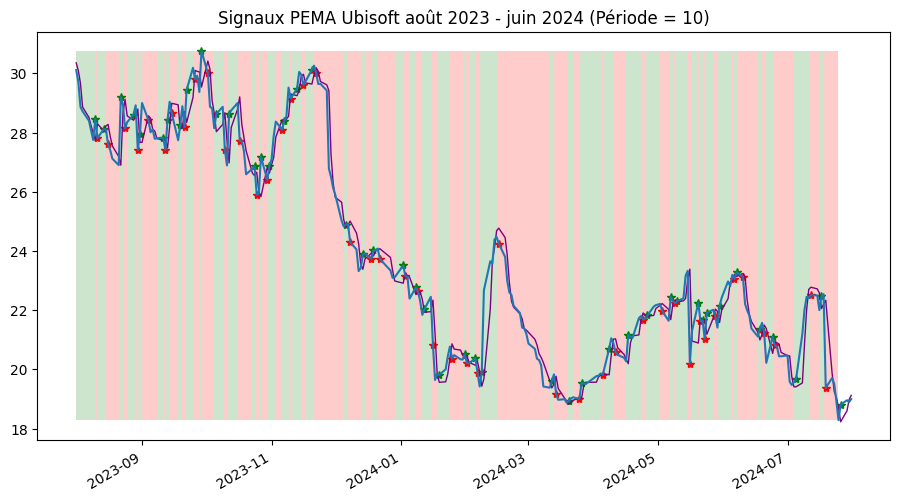

In [31]:


#Apple
hourly_apple = yahooFinance.download("AAPL", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_appleBefore = yahooFinance.download("AAPL", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_apple = yahooFinance.download("AAPL", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_apple3mois = yahooFinance.download("AAPL", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_appleBefore = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_apple, daily_appleBefore, 'Apple PEMA 1 an période ')
backTest(daily_apple3mois, daily_appleBefore, 'Apple PEMA 3 mois période ')
backTest(hourly_apple, hourly_appleBefore, 'Apple PEMA 1 mois période ', ' heures')

pemaResult(daily_apple, daily_appleBefore, 18, 'Signaux PEMA Apple août 2023 - juin 2024 (Période = 18)', True)


#BNO
hourly_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_banqueNationale3mois = yahooFinance.download("NA.TO", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_banqueNationale, daily_banqueNationaleBefore, 'Banque Nationale PEMA 1 an période ')
backTest(daily_banqueNationale3mois, daily_banqueNationaleBefore, 'Banque Nationale PEMA 3 mois période ')
backTest(hourly_banqueNationale, hourly_banqueNationaleBefore, 'Banque Nationale PEMA 1 mois période ', ' heures')

pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 20, 'Signaux PEMA Banque Nationale août 2023 - juin 2024 (Période = 20)', True)



#FOREX CA-USD
hourly_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_cadusd3mois = yahooFinance.download("CADUSD=X", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_cadusd, daily_cadusdBefore, 'CAD-USD PEMA 1 an période ')
backTest(daily_cadusd3mois, daily_cadusdBefore, 'CAD-USD PEMA 3 mois période ')
backTest(hourly_cadusd, hourly_cadusdBefore, 'CAD-USD PEMA 1 mois période ', ' heures')

pemaResult(daily_cadusd, daily_cadusdBefore, 5, 'Signaux PEMA CA-USD août 2023 - juin 2024 (Période = 5)', True)



#SP500
hourly_sp500 = yahooFinance.download("^GSPC", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_sp500Before = yahooFinance.download("^GSPC", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_sp500 = yahooFinance.download("^GSPC", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_sp5003mois = yahooFinance.download("^GSPC", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_sp500, daily_sp500Before, 'SP500 PEMA 1 an période ')
backTest(daily_sp5003mois, daily_sp500Before, 'SP500 PEMA 3 mois période ')
backTest(hourly_sp500, hourly_sp500Before, 'SP500 PEMA 1 mois période ', ' heures')

pemaResult(daily_sp500, daily_sp500Before, 28, 'Signaux PEMA SP500 août 2023 - juin 2024 (Période = 28)', True)


#ubi
hourly_ubi = yahooFinance.download("UBI.PA", start = datetime(2024,7,1), end = datetime(2024,8,1), interval = '1h')
hourly_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2024,6,10), end = datetime(2024,8,1), interval = '1h')

daily_ubi = yahooFinance.download("UBI.PA", start = datetime(2023,8,1), end = datetime(2024,8,1), interval = '1d')
daily_ubi3mois = yahooFinance.download("UBI.PA", start = datetime(2024,5,1), end = datetime(2024,8,1), interval = '1d')
daily_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2023,1,1), end = datetime(2024,8,1), interval = '1d')

backTest(daily_ubi, daily_ubiBefore, 'Ubisoft PEMA 1 an période ')
backTest(daily_ubi3mois, daily_ubiBefore, 'Ubisoft PEMA 3 mois période ')
backTest(hourly_ubi, hourly_ubiBefore, 'Ubisoft PEMA 1 mois période ', ' heures')


pemaResult(daily_ubi, daily_ubiBefore, 10, 'Signaux PEMA Ubisoft août 2023 - juin 2024 (Période = 10)', True)




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Signaux PEMA Apple août-novembre 2024 (Période = 18) Profit : 0.3788090023095769 %
Acheter action Profit:  5.376445072517333 %
Signaux PEMA Banque Nationale août-novembre 2024 (Période = 20) Profit : 4.678309332510144 %
Acheter action Profit:  16.508980812612318 %
Signaux PEMA CA-USD août-novembre 2024 (Période = 5) Profit : 0.8826451354830844 %
Acheter action Profit:  -0.7511052382717986 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Signaux PEMA SP500 août-novembre 2024 (Période = 28) Profit : 4.056799573804892 %
Acheter action Profit:  6.737861123654287 %
Signaux PEMA Ubisoft août-novembre 2024 (Période = 10) Profit : 16.879884050165895 %
Acheter action Profit:  -27.00490905547326 %


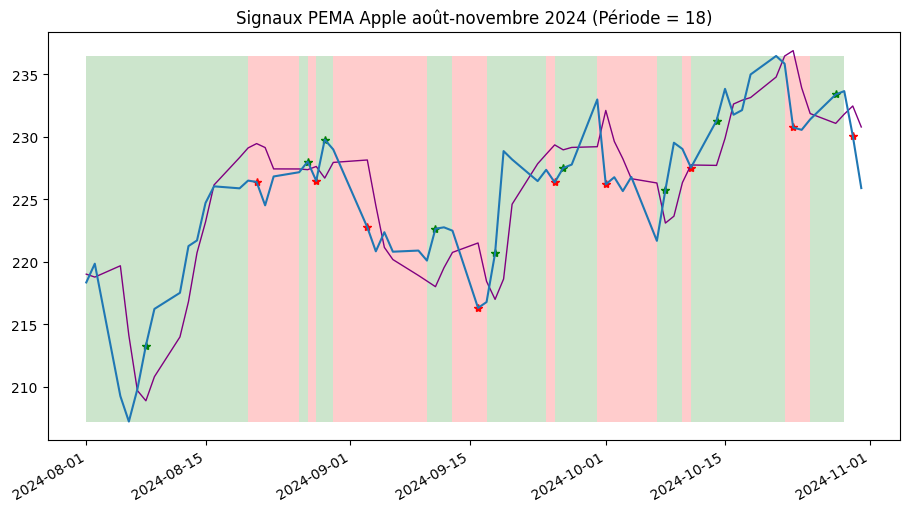

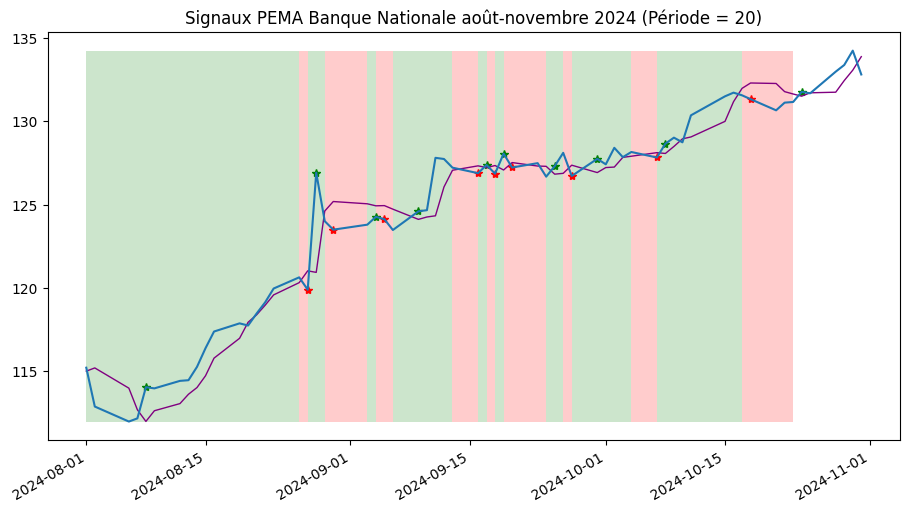

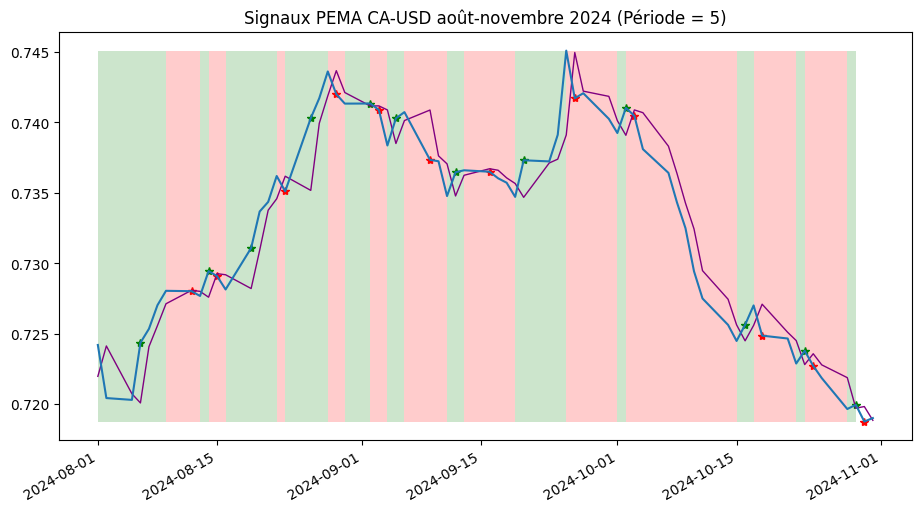

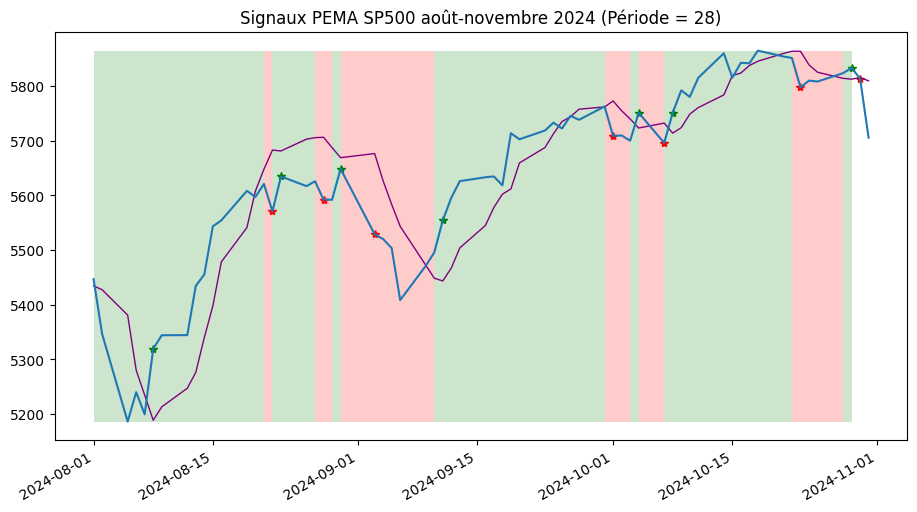

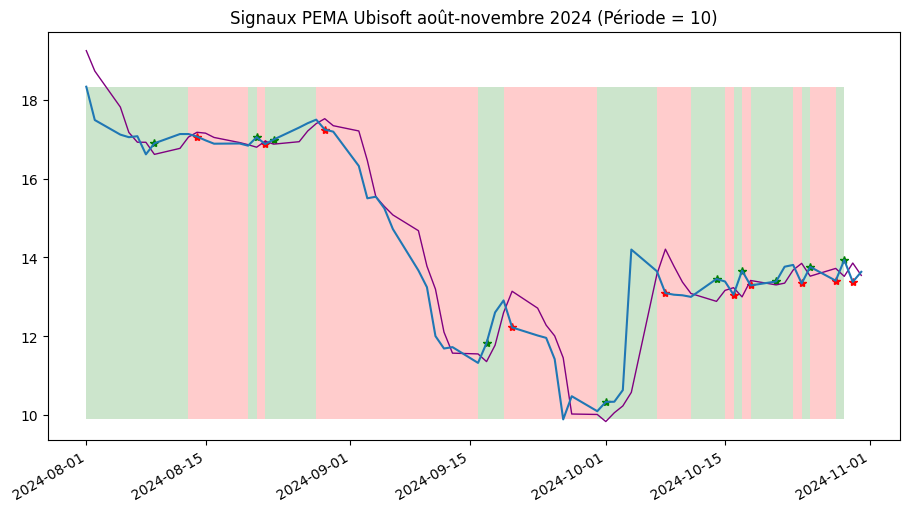

In [32]:
#Apple
portfolioApple = yahooFinance.download("AAPL", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioAppleBefore = yahooFinance.download("AAPL", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')

pemaResult(portfolioApple, portfolioAppleBefore, 18, 'Signaux PEMA Apple août-novembre 2024 (Période = 18)', True)


#BNO
portfolioBNO = yahooFinance.download("NA.TO", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioBNOBefore = yahooFinance.download("NA.TO", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioBNO, portfolioBNOBefore, 20, 'Signaux PEMA Banque Nationale août-novembre 2024 (Période = 20)', True)


#FOREX CA-USD
portfolioCAUSD = yahooFinance.download("CADUSD=X", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolioCAUSDBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioCAUSD, portfolioCAUSDBefore, 5, 'Signaux PEMA CA-USD août-novembre 2024 (Période = 5)', True)


#SP500
portfolioSP500 = yahooFinance.download("^GSPC", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolio_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioSP500, portfolio_sp500Before, 28, 'Signaux PEMA SP500 août-novembre 2024 (Période = 28)', True)

#ubi
portfolioUbi = yahooFinance.download("UBI.PA", start = datetime(2024,8,1), end = datetime(2024,11,1), interval = '1d')
portfolio_ubiBefore = yahooFinance.download("UBI.PA", start = datetime(2023,3,1), end = datetime(2024,11,1), interval = '1d')
pemaResult(portfolioUbi, portfolio_ubiBefore, 10, 'Signaux PEMA Ubisoft août-novembre 2024 (Période = 10)', True)

